In [1]:
from gates import *
from states import *
from measurements import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import cma

Done


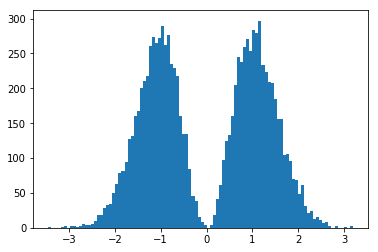

In [2]:
n_photons = 3
state1 = np.zeros(n_photons)
state1[0] = 1.
state2 = np.zeros(n_photons)
state2[0] = 1.
state3 = np.zeros(n_photons)
state3[1] = 1.
state = np.kron(state2, state3)
state = np.kron(state1, state)
data = meas_X_theta(state, 0., 3, n_photons)
plt.hist(data[:,2], bins=100)
print('Done')

# Initialization

In [3]:
n_photons = 8
# 1
vacuum_state1 = np.zeros(n_photons)
vacuum_state1[0] = 1.
# 2
vacuum_state2 = np.zeros(n_photons)
vacuum_state2[0] = 1.

state = np.kron(vacuum_state1, vacuum_state2)


# 1
# from vacuum state to displaced squeezed state
coh_dis = [0.5, 0.2, 0.3, 0.3] # squeezed r*np.exp(i*phi)  and coherent |alpha|*np.exp(i*args(alpha))
gate1_1 = S_gate(coh_dis[0], coh_dis[1], 1, 2, n_photons) 
gate1_2 = D_gate(coh_dis[2], coh_dis[3], 1, 2, n_photons)

# 2
coh_dis = [0.3, 0.4, 0.5, 0.7] # squeezed r*np.exp(i*phi)  and coherent |alpha|*np.exp(i*args(alpha))
gate2_1 = S_gate(coh_dis[0], coh_dis[1], 2, 2, n_photons) 
gate2_2 = D_gate(coh_dis[2], coh_dis[3], 2, 2, n_photons)

gate_all = BS_gate(0.1, 0.2, 1, 2, 2, n_photons)

state_ = np.einsum('jk,k->j', gate1_1, state)
state_ = np.einsum('jk,k->j', gate1_2, state_)
state_ = np.einsum('jk,k->j', gate2_1, state_)
state_ = np.einsum('jk,k->j', gate_all, state_)
init_state = np.einsum('jk,k->j', gate2_2, state_)

In [4]:
init_state

array([ 7.31441442e-01+3.34875174e-02j,  3.13400660e-01+6.89669407e-02j,
       -1.39870305e-01-2.00175915e-02j, -1.42719516e-01-5.98513632e-02j,
        2.06506548e-02+3.28161630e-04j,  6.32894996e-02+3.71304670e-02j,
       -8.27039258e-03+3.32632293e-03j, -1.82133849e-02-2.10636547e-02j,
        4.01601018e-01+2.34600883e-01j,  1.46091432e-01+1.21895582e-01j,
       -7.74747091e-02-5.92338564e-02j, -6.04268372e-02-7.25557132e-02j,
        1.54568007e-02+1.18360333e-02j,  2.18113168e-02+3.77155657e-02j,
       -4.95666136e-03-3.50853181e-03j, -4.28061133e-03-1.59471411e-02j,
       -2.58562888e-02+1.11329217e-01j, -2.34038946e-02+3.46456339e-02j,
        5.99823273e-03-2.79665331e-02j,  1.38304659e-02-1.64332261e-02j,
       -1.64060650e-04+8.80051695e-03j, -8.55438239e-03+5.99965156e-03j,
        1.20710980e-03-3.23883174e-03j,  3.10938902e-03-1.50335591e-03j,
       -9.35799745e-02-5.76758003e-02j, -3.30529329e-02-3.41093605e-02j,
        1.88562349e-02+1.20095711e-02j,  1.34223228

In [5]:
def circuit(state, params, n_photons):
    gate_bs = BS_gate(params[8], params[9], 1, 2, 2, n_photons)
    gate1_1 = D_gate(params[0], params[1], 1, 2, n_photons) 
    gate1_2 = S_gate(params[2], params[3], 1, 2, n_photons)
    gate2_1 = D_gate(params[4], params[5], 2, 2, n_photons) 
    gate2_2 = S_gate(params[6], params[7], 2, 2, n_photons)
    state_ = np.einsum('jk,k->j', gate1_1, state)
    state_ = np.einsum('jk,k->j', gate1_2, state_)
    state_ = np.einsum('jk,k->j', gate2_1, state_)
    final_state = np.einsum('jk,k->j', gate2_2, state_)
    data_X = meas_X(final_state, 2, n_photons)
    data_P = meas_P(final_state, 2, n_photons)
    return data_X, data_P, final_state

def loss_xy(x1, p1, x2, p2):
    H = np.zeros(x1.shape[0]**2, dtype=np.float32)
    dimension = x1.shape[0]
    for i in range(dimension):
        H[i*dimension:(i+1)*dimension] = (x1**2 + x2**2 + p1[i]**2 + p2[i]**2)/2.
    return np.mean(H) # + np.std(H)

In [6]:
params = [0, 1, 1, 0, 0, 1, 0, 0, 0.5, 0.5]
data = meas_X(state, 2, n_photons)
data_X, data_P, state = circuit(state, params, n_photons)
loss_xy(data_X[:,0], data_P[:,0], data_X[:,1], data_P[:,1])

2.2058446

In [7]:
def func_to_opt(params):
    X, P, _ = circuit(init_state, params, n_photons)
    return loss_xy(X[:,0], P[:,0], X[:,1], P[:,1])

In [8]:
es = cma.CMAEvolutionStrategy(10*[0.3], 0.4)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=793389, Wed Jan 22 12:59:48 2020)


In [9]:
es.optimize(func_to_opt,iterations=1000)

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.014758348464966e+00 1.0e+00 3.81e-01  4e-01  4e-01 1:27.2
    2     20 1.497910618782043e+00 1.2e+00 3.65e-01  4e-01  4e-01 2:54.2
    3     30 1.545852184295654e+00 1.2e+00 3.70e-01  3e-01  4e-01 4:19.0


KeyboardInterrupt: 

In [10]:
params = es.result_pretty().xbest
circuit(init_state, params, n_photons)[2]

final/bestever f-value = 1.545852e+00 1.497911e+00
incumbent solution: [-0.37755847  0.53567812 -0.12007488  0.218997   -0.44965636  0.37076938
 -0.05457992 -0.114759   ...]
std deviations: [0.37715354 0.37055833 0.34413606 0.35980796 0.38021048 0.36077137
 0.36868857 0.36155866 ...]


array([ 8.38614528e-01+6.46833166e-02j, -1.90665022e-02+3.52079950e-02j,
       -1.87704892e-01-2.68948737e-02j,  8.12735681e-03-1.32555028e-02j,
        5.14390009e-02+1.06676061e-02j, -2.18106078e-03+5.33849668e-03j,
       -1.49390386e-02-6.05961110e-03j,  3.25908803e-03-5.00962949e-03j,
        3.38651246e-01+2.39293188e-01j, -2.83387292e-02-1.03091547e-03j,
       -7.15398677e-02-5.91935177e-02j,  1.10008832e-02+1.06456996e-03j,
        1.79068616e-02+1.72590435e-02j, -3.56193690e-03-7.93656019e-04j,
       -2.87560329e-03-5.19999602e-03j,  8.30695368e-04-1.74739064e-03j,
       -1.56610038e-01+3.00336701e-02j, -1.20802029e-03-1.80258690e-02j,
        3.64801054e-02-3.96798038e-03j, -4.73228412e-06+6.97085615e-03j,
       -1.05078536e-02-1.89356479e-04j,  3.69856513e-04-2.67666886e-03j,
        3.45848278e-03+1.44135356e-03j, -8.92984926e-04+1.70045708e-04j,
       -1.17708303e-01-1.28612360e-01j,  1.26887216e-02-1.83651505e-04j,
        2.42249702e-02+3.10860002e-02j, -4.93156206

In [11]:
n_photons = 8
# 1
vacuum_state1 = np.zeros(n_photons)
vacuum_state1[0] = 1.
# 2
vacuum_state2 = np.zeros(n_photons)
vacuum_state2[0] = 1.

state = np.kron(vacuum_state1, vacuum_state2)

data_X = meas_X(state, 2, n_photons)
data_P = meas_P(state, 2, n_photons)

print('final wanted loss ------- ', loss_xy(data_X[:,0], data_P[:,0], data_X[:,1], data_P[:,1]))

final wanted loss -------  1.0083091


# Simultaneous measurments of x and p

In [7]:
n_photons = 10
state = 0./np.sqrt(n_photons)*np.ones(n_photons)
state[0] = 1.
a = sim_mes_xp(state,1,n_photons)

Done


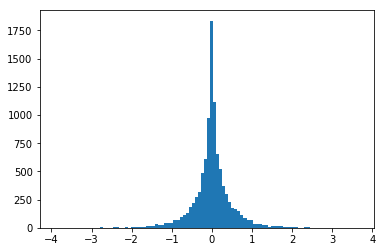

In [8]:
plt.hist(a[:,0]*a[:,1], bins=100)
print('Done')